In [228]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
import scipy.spatial
from scipy.spatial import ConvexHull
import numpy as np
import math
from pyproj import Geod

In [11]:
source = "countries.geojson"
output_directory = Path("country_outlines")
output_directory.mkdir(exist_ok=True)
geo_file = gpd.read_file(source)


In [15]:

def get_all_data():
    print("Rows:", len(geo_file))
    #print(geo_file.columns)
    name_columns = "ADMIN" if "ADMIN" in geo_file.columns else "NAME" if "NAME" in geo_file.columns else geo_file.columns[0]
    
    
    for index, row in geo_file.iterrows():
        name = str(row[name_columns]).replace("/", "_").replace(" ", "_")
        country_gdf = gpd.GeoDataFrame([row], crs=geo_file.crs)
    
        country_gdf.to_file(output_directory / f"{name}.geojson", driver="GeoJSON")
    
        fig, ax = plt.subplots(figsize=(4,4), dpi=200)
        country_gdf.boundary.plot(ax=ax, linewidth=1)
    
        ax.set_axis_off()
        plt.tight_layout(pad=0)
        plt.savefig(output_directory / f"{name}.png", bbox_inches="tight", pad_inches=0, transparent=True)
        plt.close(fig)

#get_all_data()

In [242]:
#print(geo_file.name)
all_countries = geo_file.name

country = "Sweden"

def exterior_coordinates(country):
    status = False
    try:
        geo_file_test = gpd.read_file(output_directory / f"{country}.geojson")
        status = True
    except FileNotFoundError:
        print(f"Country '{country}' does not exist")

        
    if status:
        geometry_values = geo_file_test.geometry.values[0]

        if isinstance(geometry_values, Polygon):
            print(f"Polygon values found for {country}")
            return [list(geometry_values.exterior.coords)]
        elif isinstance(geometry_values, MultiPolygon):
            print(f"MultiPolygon values found for {country}")
            return [list(poly.exterior.coords) for poly in geometry_values.geoms]
        else:
            print(f"Unknown datatype found for {country}")
            return None
#coords = exterior_coordinates(country)
#print(len(coords))


In [247]:
def mainland_min_rectangle(coordinates,country):
    convexhull = ConvexHull(coordinates)
    #print("Vertices count: ", len(convexhull.vertices)) 
    #print(convexhull.vertices)
    
    corner_list = []

    for c in convexhull.vertices:
        corner_list.append(coordinates[c])
    corner_list.append(corner_list[0]) # To close the loop
    #print(corner_list)
    x1, y1 = zip(*corner_list)
    x2, y2 = zip(*coordinates)

    hull_polygon = Polygon(coordinates)
    min_rectangle = hull_polygon.minimum_rotated_rectangle
    polygon_area = hull_polygon.area
        
    rect_coords = list(min_rectangle.exterior.coords)

    x_rect, y_rect = zip(*rect_coords)

    
    
    plt.figure(figsize=(5,5))
    plt.plot(x1, y1, color='blue', label="Convexhull")   
    plt.plot(x2, y2, color='red', label="Mainland outline")   
    plt.plot(x_rect, y_rect, color='black', linewidth=2, label="Min rect")
    
    plt.axis('equal') 
    plt.legend()
    plt.savefig(output_directory / f"{country}_ConvexHull_MainLand.png", dpi=100, bbox_inches='tight', transparent=True)
    plt.show()

    return min_rectangle,polygon_area
    
#mainland_coords = coords[0]
#min_rectangle, poly_area = mainland_min_rectangle(mainland_coords,country)

def angle_shifted(coords):

    # First edge vector
    (x0, y0), (x1, y1) = rect_coords[0], rect_coords[1]
    dx, dy = x1 - x0, y1 - y0
    
    # Compute angle in degrees
    angle_rad = math.atan2(dy, dx)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg % 180

def geodesic_area(coords):
    poly = Polygon(coords)
    geod = Geod(ellps="WGS84") #Earth ellipsoid
    area, _ = geod.geometry_area_perimeter(poly)
    return abs(area)
    

MultiPolygon values found for Germany


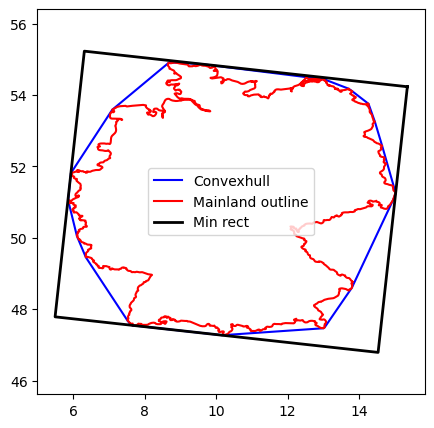

Germany Rectangle area: 68.13619431745873
Germany Polygon area: 45.658372045230074
Rectangle-score for Germany is: 67.01045237792346


In [255]:
country = "Germany"

def run_everything(country):
    coords = exterior_coordinates(country)
    mainland_coords = coords[0]

    
    min_rectangle, poly_area = mainland_min_rectangle(mainland_coords,country)
    
    bounds = min_rectangle.bounds
    rec_area = min_rectangle.area
    angle_rotated = angle_shifted(bounds)
    rec_ratio = poly_area / rec_area
    
    
    print(f"{country} Rectangle area: {rec_area}")
    print(f"{country} Polygon area: {poly_area}")
    #print(f"The rectangle-ratio for {country} is: {rec_ratio}")
    print(f"Rectangle-score for {country} is: {rec_ratio*100}")



run_everything(country)


In [ ]:
############################################################################################
############################################################################################
############################################################################################
############################################################################################

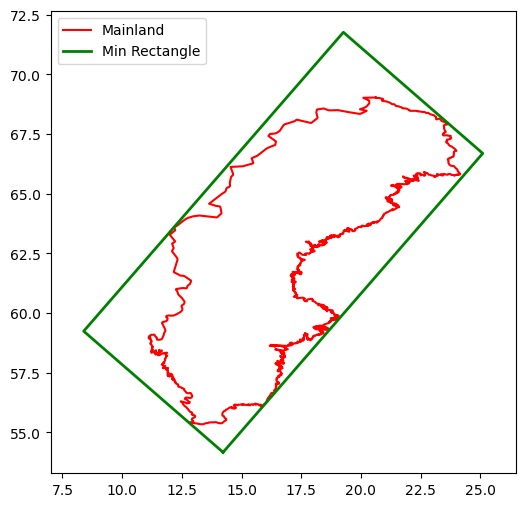

In [209]:
#Self-written rotating calipers algorithm. Not used in this program however..

def rotate_coords(coords, angle):
    rot_matrix = np.array([[math.cos(angle), -math.sin(angle)],
                           [math.sin(angle),  math.cos(angle)]])
    return np.dot(coords, rot_matrix.T)

def min_rect_poly(coords):
    coords = np.array(coords)
    hull = ConvexHull(coords)
    hull_coords = coords[hull.vertices]

    min_area = float("inf")
    best_rect = None
    best_angle = None

    for k in range(len(hull_coords)):
        p1 = hull_coords[k]
        p2 = hull_coords[(k+1) % len(hull_coords)]
        vert = p2 - p1

        angle = math.atan2(vert[1], vert[0])  # angle to x-axis

        rotated = rotate_coords(hull_coords, -angle)

        min_x, max_x = np.min(rotated[:,0]), np.max(rotated[:,0])
        min_y, max_y = np.min(rotated[:,1]), np.max(rotated[:,1])

        area = (max_x - min_x) * (max_y - min_y)

        if area < min_area:
            min_area = area
            best_rect = (min_x, min_y, max_x, max_y)
            best_angle = angle

    min_x, min_y, max_x, max_y = best_rect
    rect_coords_rotated = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y],
        [min_x, min_y]  # close loop
    ])

    rect_coords = rotate_coords(rect_coords_rotated, best_angle)
    return rect_coords

rect_coords = min_rect_poly(mainland_coords)

plt.figure(figsize=(6,6))
plt.plot(np.array(mainland_coords)[:,0], np.array(mainland_coords)[:,1], 'r-', label="Mainland")
plt.plot(rect_coords[:,0], rect_coords[:,1], 'g-', linewidth=2, label="Min Rectangle")
plt.axis('equal')
plt.legend()
plt.show()
